# Modeling
##### _Author: Calvin Chi_

---

Load packages and set data and output directories

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import pickle
from sklearn import grid_search
import sklearn.preprocessing as pp
import matplotlib.pyplot as plt
import time
import random
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.cross_validation import train_test_split

dataDir = "data/"
fileDir = "../data/payerChurnData.csv"
outputDir = "output/"

Load the data

In [52]:
Xtrain = pickle.load(open(dataDir + "Xtrain.p", "rb"))
ytrain = pickle.load(open(dataDir + "ytrain.p", "rb"))
Xtest = pickle.load(open(dataDir + "Xtest.p", "rb"))
ytest = pickle.load(open(dataDir + "ytest.p", "rb"))

In our dataset we have 83.2% churn-players and 16.8% non-churn players, so we may need to bootstrap our non-churn playes so that we have roughly 50% samples from each class.

In [28]:
negIdx = np.where(ytrain == 0)[0]
posIdx = np.where(ytrain == 1)[0]
posTot = len(negIdx) - len(posIdx)
BSidx = np.random.choice(negIdx, posTot)
idx = np.random.permutation(np.hstack((negIdx, posIdx, BSidx)))
XtrainBS = Xtrain.iloc[idx, :]
ytrainBS = ytrain.iloc[idx]
print(XtrainBS.shape)

(97086, 270)


# K-Nearest Neighbors

In [62]:
from sklearn.neighbors import KNeighborsClassifier

### Non-Bootstrap
Get user Ids for train and test datasets

In [63]:
allIds = data['idfa']
trainId = allIds[Xtrain.index.values].values
testId = allIds[Xtest.index.values].values

Scale the data

In [64]:
Xtrain = pp.scale(Xtrain)
Xtest = pp.scale(Xtest)

kNN modeling

In [65]:
knn = KNeighborsClassifier()
neighbors = [2**i for i in range(2, 11)]
parameters = {'n_neighbors':neighbors}
clf = grid_search.GridSearchCV(knn, parameters, scoring='average_precision', cv=3, verbose=True)
clf.fit(Xtrain, ytrain)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 110.7min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [4, 8, 16, 32, 64, 128, 256, 512, 1024]},
       pre_dispatch='2*n_jobs', refit=True, scoring='average_precision',
       verbose=True)

In [69]:
gridScores = clf.grid_scores_
clf.grid_scores_

[mean: 0.54607, std: 0.00476, params: {'n_neighbors': 4},
 mean: 0.56461, std: 0.00374, params: {'n_neighbors': 8},
 mean: 0.57506, std: 0.00415, params: {'n_neighbors': 16},
 mean: 0.58044, std: 0.00378, params: {'n_neighbors': 32},
 mean: 0.57796, std: 0.00592, params: {'n_neighbors': 64},
 mean: 0.56382, std: 0.00658, params: {'n_neighbors': 128},
 mean: 0.53582, std: 0.00676, params: {'n_neighbors': 256},
 mean: 0.50566, std: 0.00482, params: {'n_neighbors': 512},
 mean: 0.49258, std: 0.00734, params: {'n_neighbors': 1024}]

To get all the mean accuracy scores

In [70]:
means = []
for item in gridScores: 
    means.append(item[1])

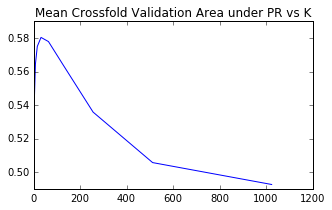

In [71]:
%matplotlib inline
plt.figure(figsize=(5, 3))
plt.title("Mean Crossfold Validation Area under PR vs K")
plt.plot(neighbors, means)
plt.show()

In [72]:
print("Best parameter: ")
print(clf.best_params_)

Best parameter: 
{'n_neighbors': 32}


It looks like `k = 32` is the best parameter for k-NN. Let us evaluate its performance on the test set. First predict probability and output area under the ROC curve.

In [73]:
knn = KNeighborsClassifier(n_neighbors=32)
knn.fit(Xtrain, ytrain)
prob = knn.predict_proba(Xtest)[:, 1]

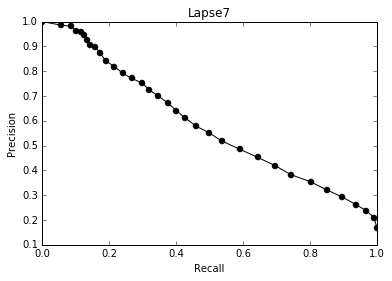

In [74]:
precision, recall, thresholds = precision_recall_curve(ytest, prob)
plt.plot(recall, precision, "o-", color="black")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Lapse7")
plt.show()

In [75]:
area = average_precision_score(ytest, prob)
print("Area under PR Curve")
print(area)

Area under PR Curve
0.587723426206


And also evaluate the accuracy

In [76]:
pred = knn.predict(Xtest)
print("Accuracy: ")
print(np.mean(pred == ytest))

Accuracy: 
0.865551976975


### Bootstrap

First scale the data

In [77]:
XtrainBS = pp.scale(XtrainBS)
Xtest = pp.scale(Xtest)

Tune the hyperparameter

In [ ]:
knn = KNeighborsClassifier()
neighbors = [2**i for i in range(5, 11)]
parameters = {'n_neighbors':neighbors}
clf = grid_search.GridSearchCV(knn, parameters, scoring='roc_auc', cv=3, verbose=True)
clf.fit(XtrainBS, ytrainBS)

In [9]:
clf.grid_scores_

[mean: 0.75026, std: 0.00345, params: {'n_neighbors': 32},
 mean: 0.75254, std: 0.00204, params: {'n_neighbors': 64},
 mean: 0.75149, std: 0.00106, params: {'n_neighbors': 128},
 mean: 0.74607, std: 0.00085, params: {'n_neighbors': 256},
 mean: 0.73845, std: 0.00029, params: {'n_neighbors': 512},
 mean: 0.72276, std: 0.00214, params: {'n_neighbors': 1024}]

It looks like 64 neighbors is best for the bootstrap sample. Let us evaluate the model on the test set.

In [78]:
knn = KNeighborsClassifier(n_neighbors=32)
knn.fit(XtrainBS, ytrainBS)
predProb = knn.predict_proba(Xtest)[:, 1]

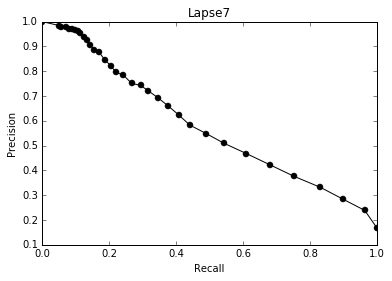

In [84]:
precision, recall, thresholds = precision_recall_curve(ytest, predProb)
plt.plot(recall, precision, "o-", color="black")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Lapse7")
plt.show()

In [85]:
area = average_precision_score(ytest, predProb)
print("Area under PR Curve")
print(area)

Area under PR Curve
0.580863395555


In [86]:
pred = knn.predict(Xtest)
print("Accuracy: ")
print(np.mean(pred == ytest))

Accuracy: 
0.859727266498


Confusion matrix

In [88]:
pd.crosstab(ytest, pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,12010,136,12146
1,1911,536,2447
All,13921,672,14593


In conclusion k-NN does not perform well according to recall objective 

# SVM

Import packages

In [62]:
from sklearn.svm import SVC

Scale the data:

In [51]:
features = Xtrain.columns.values
Xtrain = pd.DataFrame(pp.scale(Xtrain))
Xtrain.columns = features
Xtest = pd.DataFrame(pp.scale(Xtest))
Xtest.columns = features

Subset the data based on selected attributes from decision tree

In [80]:
attributes = pickle.load(open(outputDir + "attributes.p", "rb"))
XtrainSub = Xtrain.ix[:, attributes]
XtestSub = Xtest.ix[:, attributes]
print(XtrainSub.shape)
print(XtestSub.shape)

(58369, 34)
(14593, 34)


Below is sample code for hyperparameter tuning for SVM. Hyperparameter tuning is not run in Juypter Notebook in the interest of computational time. We have prior knowledge that a `rbf` kernel works better than a `polynomial` kernel.
```python
svm = SVC(probability=True)
Cs = [2**i for i in range(-3, 4)]
kernels = ['poly', 'rbf']
degrees = [2, 3]
parameters = {'C':Cs, 'kernel':kernels, 'degree':degrees}
clf = grid_search.GridSearchCV(svm, parameters, cv=3, n_jobs=2, 
	scoring='roc_auc', verbose=True)
clf.fit(XtrainSub, ytrain)
```

Load scores after turning

In [109]:
clf2 = pickle.load(open(outputDir + "svmTune.p", "rb"))

Print out the scores

In [110]:
clf2.grid_scores_

[mean: 0.51562, std: 0.01984, params: {'C': 0.25},
 mean: 0.51209, std: 0.01423, params: {'C': 0.5},
 mean: 0.50464, std: 0.00931, params: {'C': 1},
 mean: 0.49618, std: 0.00293, params: {'C': 2},
 mean: 0.48328, std: 0.00118, params: {'C': 4},
 mean: 0.46871, std: 0.00614, params: {'C': 8},
 mean: 0.45674, std: 0.00793, params: {'C': 16},
 mean: 0.44262, std: 0.00613, params: {'C': 32},
 mean: 0.43170, std: 0.00202, params: {'C': 64},
 mean: 0.42833, std: 0.00431, params: {'C': 128}]

It appears that C=0.25 is the best parameter.

Train
```python 
svm = SVC(probability=True, kernel='rbf', C=512)
svm.fit(XtrainSub, ytrain)
```

In [85]:
svm = pickle.load(open(outputDir + "svm.p", "rb"))

Predict on test set

In [86]:
pred = svm.predict(XtestSub)
print("Accuracy: ")
print(np.mean(pred == ytest))

Accuracy: 
0.593503734667


Evaluate area under the PR curve

In [87]:
prob = svm.predict_proba(XtestSub)[:, 1]
area = average_precision_score(ytest, prob)
print("Area under PR Curve")
print(area)

Area under PR Curve
0.45928469179


Confusion matrix

In [88]:
pd.crosstab(ytest, pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,6413,5764,12177
1,168,2248,2416
All,6581,8012,14593


Plot the PR curve

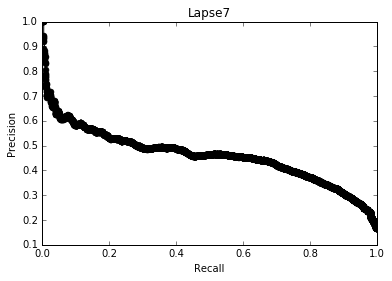

In [89]:
%matplotlib inline
precision, recall, thresholds = precision_recall_curve(ytest, prob)
plt.plot(recall, precision, "o-", color="black")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Lapse7")
plt.show()

In [98]:
pickle.dump(pred, open(outputDir + "svm.prediction.p", 'wb'))

# Logistic Regression

In [39]:
from sklearn.linear_model import LogisticRegression

Scale the data:

In [40]:
features = Xtrain.columns.values
Xtrain = pd.DataFrame(pp.scale(Xtrain))
Xtrain.columns = features
Xtest = pd.DataFrame(pp.scale(Xtest))
Xtest.columns = features

Subset the data based on selected attributes from decision tree

In [41]:
attributes = pickle.load(open(outputDir + "attributes.p", "rb"))
XtrainSub = Xtrain.ix[:, attributes]
XtestSub = Xtest.ix[:, attributes]

Tune the model

In [94]:
Cs = [2**i for i in range(-4, 8)]
lr = LogisticRegression(class_weight={0:0.1, 1:0.9})
parameters = {'C':Cs}
clf = grid_search.GridSearchCV(lr, parameters, cv=3, scoring='average_precision', 
                               verbose=True)
clf.fit(Xtrain, ytrain)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  2.2min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight={0: 0.1, 1: 0.9}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128]},
       pre_dispatch='2*n_jobs', refit=True, scoring='average_precision',
       verbose=True)

In [99]:
gridScores = clf.grid_scores_
gridScores

[mean: 0.51020, std: 0.00847, params: {'C': 0.0625},
 mean: 0.51007, std: 0.00832, params: {'C': 0.125},
 mean: 0.50986, std: 0.00811, params: {'C': 0.25},
 mean: 0.50971, std: 0.00799, params: {'C': 0.5},
 mean: 0.50952, std: 0.00796, params: {'C': 1},
 mean: 0.50938, std: 0.00796, params: {'C': 2},
 mean: 0.50931, std: 0.00795, params: {'C': 4},
 mean: 0.50926, std: 0.00795, params: {'C': 8},
 mean: 0.50924, std: 0.00795, params: {'C': 16},
 mean: 0.50924, std: 0.00795, params: {'C': 32},
 mean: 0.50923, std: 0.00795, params: {'C': 64},
 mean: 0.50923, std: 0.00795, params: {'C': 128}]

It looks like the best regularization parameter `C` is 0.0625.

In [42]:
Xtrain = pp.scale(Xtrain)
Xtest = pp.scale(Xtest)
lr = LogisticRegression(C=0.0625, class_weight={1: 0.9, 0:0.1})
lr.fit(Xtrain, ytrain)
predProb = lr.predict_proba(Xtest)[:, 1]
pr = average_precision_score(ytest, predProb)
print("Area under PR curve: ")
print(pr)

Area under PR curve: 
0.50146880324


The Accuracy

In [43]:
pred = lr.predict(Xtest)
print("Accuracy: ")
print(np.mean(pred == ytest))

Accuracy: 
0.604125265538


In [44]:
pd.crosstab(ytest, pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,6554,5586,12140
1,191,2262,2453
All,6745,7848,14593


Plot the PR curve

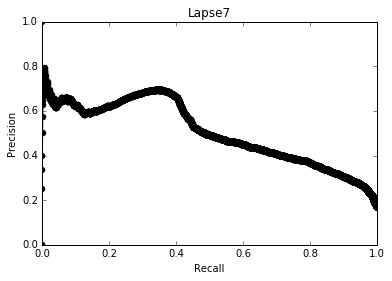

In [45]:
%matplotlib inline
precision, recall, thresholds = precision_recall_curve(ytest, predProb)
plt.plot(recall, precision, "o-", color="black")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Lapse7")
plt.show()

Save the predictions

In [105]:
pickle.dump(predProb, open(outputDir + "logistic.prediction.p", 'wb'))

# Random Forests

In [66]:
from sklearn.ensemble import RandomForestClassifier

Hyperparameter turning for number of trees and class weights. Actual code run in `code/RandomForest.py`

```python
n_estimators = list(range(30, 110, 10))
class_weights = [{0:0.2, 1:0.8}, {0:0.15, 1:0.85}, {0:0.1, 1:0.9}, {0:0.05,  1:0.95}]
parameters = {'n_estimators':n_estimators, 'class_weight':class_weights}
rf = RandomForestClassifier(max_depth=6)
clf = grid_search.GridSearchCV(rf, parameters, cv=3, scoring='average_precision', 
                               verbose=True)
clf.fit(Xtrain, ytrain)
```

In [147]:
clf = pickle.load(open(outputDir + "RandomForestTune.p", 'rb'))

What are the best parameters

In [148]:
clf.best_params_

{'class_weight': {0: 0.05, 1: 0.95}, 'n_estimators': 50}

Train and assess accuracy

In [71]:
clf = RandomForestClassifier(n_estimators=50, class_weight={0:0.1, 1:0.90}, max_depth=8)
clf.fit(Xtrain, ytrain)
pred = clf.predict(Xtest)
np.mean(pred == ytest)

0.71308161447269236

Assess area under PR curve

In [72]:
prob = clf.predict_proba(Xtest)[:, 1]
pr = average_precision_score(ytest, prob)
print("Area under PR curve: ")
print(pr)

Area under PR curve: 
0.662034046921


Plot the PR curve:

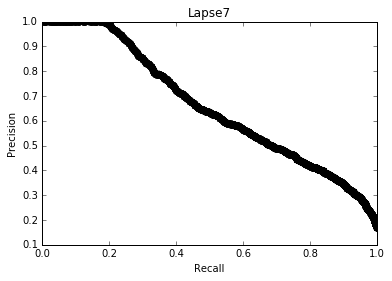

In [73]:
%matplotlib inline
precision, recall, thresholds = precision_recall_curve(ytest, prob)
plt.plot(recall, precision, "o-", color="black")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Lapse7")
plt.show()

Confusion matrix

In [74]:
pd.crosstab(ytest, pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,8235,3905,12140
1,282,2171,2453
All,8517,6076,14593


Save the result

In [75]:
pickle.dump(prob, open(outputDir + "RandomForest.prediction.p", 'wb'))

# Quadratic Discriminant Analysis

In [4]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

For QDA, bootstrapping our positive class could help because it could make our Gaussian densities "tigher", so we will train using the bootsrapped dataset.

In [54]:
attributes = pickle.load(open(outputDir + "attributes.p", "rb"))
Xtrain = Xtrain.ix[:, attributes]
Xtest = Xtest.ix[:, attributes]

Scale the data

In [49]:
Xtrain = pp.scale(Xtrain)
Xtest = pp.scale(Xtest)

Train and predict

In [64]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(Xtrain, ytrain)
pred = qda.predict(Xtest)
print("Accuracy: ")
print(np.mean(pred == ytest))
prob = qda.predict_proba(Xtest)[:, 1]
pr = average_precision_score(ytest, prob)
print("Area under recall curve: ")
print(pr)

Accuracy: 
0.506612759542
Area under recall curve: 
0.591806021759


Confusion matrix

In [65]:
pd.crosstab(ytest, pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,5099,7041,12140
1,159,2294,2453
All,5258,9335,14593


Save the predictions

In [137]:
pickle.dump(prob, open(outputDir + "QDA.prediction.p", 'wb'))

# Neural Network

In [4]:
from sklearn.neural_network import MLPClassifier

Assess the dimenions of our input:

In [5]:
Xtrain.shape

(58369, 153)

We are going to use a one layer neural network with number of neurons equal to the average betweent the input and output neurons, which is 78. 

```python
nn = Classifier(
    layers=[
        Layer("Rectifier", units=78),
        Layer("Softmax")],
    learning_rate=0.001,
    verbose=True,
    n_iter=20)
```

Scale the data

In [144]:
Xtrain = pp.scale(Xtrain)
Xtest = pp.scale(Xtest)

Train

```python
nn.fit(Xtrain, ytrain)
```

Load the trained model

In [50]:
nn = pickle.load(open(outputDir + "nn.p", 'rb'))

Predict and assess accuracy

In [51]:
pred = nn.predict(Xtest)
np.mean(pred == ytest)

0.22757486466113891

In [52]:
prob = nn.predict_proba(Xtest)[:, 1]
pr = average_precision_score(ytest, prob)
print("Area under recall curve: ")
print(pr)

Area under recall curve: 
0.415208407798


In [53]:
pd.crosstab(ytest, pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,1013,11164,12177
1,108,2308,2416
All,1121,13472,14593


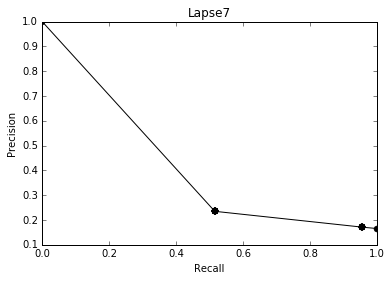

In [54]:
%matplotlib inline
precision, recall, thresholds = precision_recall_curve(ytest, prob)
plt.plot(recall, precision, "o-", color="black")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Lapse7")
plt.show()